In [711]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from scipy.stats import norm
import pymc as pm
from scipy.linalg import block_diag
import copy

In [712]:
dates = pd.date_range(start='1/1/2013', end='6/1/2014')
cov_1 = np.sin(2*np.pi/90 * days) + 10
cov_2 = np.sin(2*np.pi/360 * days) + 10
covs = np.vstack([cov_1, cov_2])

In [713]:
def make_block(A, B):
    mat = np.block([[A, np.zeros([A.shape[0], B.shape[1]])], [np.zeros([B.shape[0], A.shape[1]]), B]])
    return mat
    

In [714]:
# local linear trend
Z_1 = np.ones(len(dates)).reshape(1, -1)
T_1 = np.ones(1).reshape(-1, 1)
R_1 = np.eye(1).reshape(-1, 1)
eta_1 = norm(0, .1).rvs(size=(1, len(dates)-1))

# dynamic regression
Z_2 = covs
T_2 = np.eye(covs.shape[0])
R_2 = np.eye(covs.shape[0])
eta_2 = norm(0, .01).rvs(size=(2, len(dates)-1))

# combine arrays
Z = np.vstack([Z_1 , Z_2[0, :], Z_2[1, :]])
T = make_block(T_1, T_2)
R = make_block(R_1, R_2)
eta = np.vstack([eta_1, eta_2])

In [715]:
alpha = np.zeros((3, len(dates)))
alpha[:, 0] = [0, 1, 1]
for i in range(len(dates)-1):
    alpha[:, i+1] = alpha[:, i]@T  +  norm(0, .1).rvs() + R@eta[:, 0]

In [716]:
y = (Z * alpha).sum(axis=0) + norm(0, .1).rvs(len(dates))
y_observed = copy.copy(y)

In [717]:
idx = int(np.where(dates ==  '2014-01-01')[0])
uplift = .2
y_observed[idx:] = y_observed[idx:] * (1 + uplift)

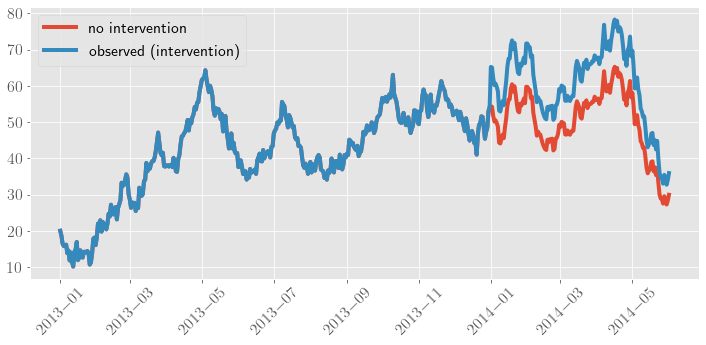

In [718]:
plt.figure(figsize=(12, 5))
plt.plot(dates, y, label='no intervention')
plt.plot(dates, y_observed, label='observed (intervention)')
plt.xticks(rotation=45)
plt.legend();

In [692]:
def draw_betas(betas, idx, sig):
    betas[idx+1] = norm(betas[idx], sig).rvs()
    return betas

def draw_mus(mus, idx, sig):
    mus[idx+1] = norm(mus[idx], sig).rvs()
    return mus
    
def make_betas_vector(n, sig=.01):
    betas = np.ones(n)
    for idx in range(n-1):
        betas = draw_betas(betas, idx, sig)
    return betas

def make_mus_vector(n, sig=.1):
    mus = np.zeros(n)
    for idx in range(n-1):
        mus = draw_mus(mus, idx, sig)
    return mus

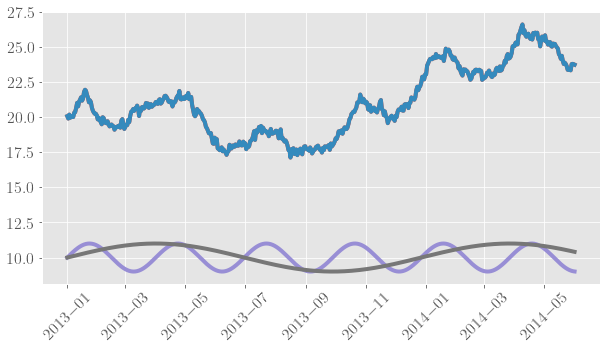

In [693]:
days = np.arange(0, len(dates), 1)

beta_1 = make_betas_vector(len(dates))
beta_2 = make_betas_vector(len(dates))
mus = make_mus_vector(len(dates))
eps = norm(0, .1).rvs(len(dates))
uplift = .2
data = beta_1*cov_1 + beta_2*cov_2 + mus + eps
plt.figure(figsize=(10, 5))
plt.plot(dates, data)


plt.xticks(rotation=45)
plt.plot(dates, data)
plt.plot(dates, cov_1)
plt.plot(dates, cov_2)

In [160]:
with pm.Model() as model:
    sig_1 = np.sqrt(pm.InverseGamma('sig1', 0.5, 0.5))
    sig_2 = np.sqrt(pm.InverseGamma('sig2', 0.5, 0.5))                
    sig_mu = np.sqrt(pm.InverseGamma('sig_mu', 0.5, 0.5))
    betas_1 = make_betas_vector(idx, sig_1.eval())
    betas_2 = make_betas_vector(idx, sig_2.eval())
    mus =  make_mus_vector(idx, sig_mu.eval())
    eps = np.sqrt(pm.InverseGamma('sigma', 0.5, 0.5))
    like = pm.Normal('like', betas_1 * cov_1[:idx] + betas_2 * cov_2[:idx] + mus, eps, observed=data[:idx])
    traces = pm.sample(return_inferencedata=None, target_accept=.99, chains=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sig1, sig2, sig_mu, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 8 seconds.


In [162]:
betas_1

array([ 1.        ,  2.2212222 ,  1.52507891,  1.53170323,  1.55004563,
        2.4119678 ,  3.75377864,  3.35684428,  2.34900485,  2.78444266,
        2.61214533,  2.41823559,  2.28514533,  2.10682589,  2.20061773,
        2.29020146,  2.28979486,  1.46402196,  0.563329  ,  1.55152075,
        1.48634864,  1.1489451 ,  1.44808167,  1.59442491,  0.27996461,
        1.95793109,  2.44673489,  3.74469056,  4.83350804,  6.3179777 ,
        5.64060246,  4.38770087,  4.78163334,  4.19844043,  4.56511943,
        4.77741127,  5.58001738,  5.47685237,  6.28396746,  6.40708959,
        5.3435623 ,  6.38357387,  5.57581692,  6.47158603,  6.40014709,
        6.15282506,  5.72049101,  5.16985533,  5.49270808,  4.21077288,
        4.26117946,  3.34107005,  3.43072276,  1.71966841,  1.745941  ,
        2.30071037,  0.78267231,  0.73831564,  2.25389932,  1.6860256 ,
        3.71716753,  3.99001243,  3.3605783 ,  3.01991277,  1.68813476,
        0.29864761,  0.60110769,  0.34367229,  1.08810108,  1.15

In [157]:
traces['like']

KeyError: 'Unknown variable like'

(array([998.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([7.41615641e-02, 1.90740016e+04, 3.81479291e+04, 5.72218566e+04,
        7.62957840e+04, 9.53697115e+04, 1.14443639e+05, 1.33517566e+05,
        1.52591494e+05, 1.71665421e+05, 1.90739349e+05]),
 <BarContainer object of 10 artists>)

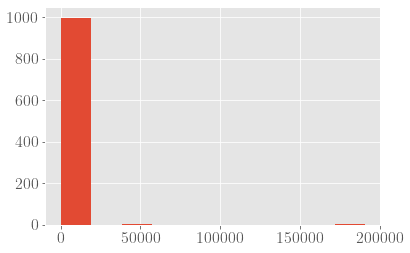

In [156]:
plt.hist(traces['sig1'
               ])

In [90]:
betas_1_mean = traces['betas1'].mean(axis=0)
betas_2_mean = traces['betas2'].mean(axis=0)
mus_mean = traces['mus'].mean(axis=0)
betas_1_full = np.concatenate([betas_1_mean, np.zeros(len(dates)-idx)])
betas_2_full = np.concatenate([betas_2_mean, np.zeros(len(dates)-idx)])
mus_full = np.concatenate([mus_mean, np.zeros(len(dates)-idx)])

for idx in range(idx, len(n_pred)):
    betas_1_full[idx] = norm(betas_1_full[idx], )

KeyError: 'Unknown variable betas1'

In [60]:
betas_1_full[idx]

0.0

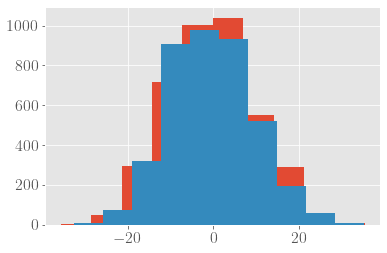

In [47]:
plt.hist(traces['mus'][:, 0]);
plt.hist(traces['mus'][:, 5]);